## ANÁLISE DO PROBLEMA

Detalhes
O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o Dicionário dos Microdados do Enem 2016.

Muitas universidades brasileiras utilizam o ENEM para selecionar seus futuros alunos e alunas. Isto é feito com uma média ponderada das notas das provas de matemática, ciências da natureza, linguagens e códigos, ciências humanas e redação, com os pesos abaixo:

matemática: 3
ciências da natureza: 2
linguagens e códigos: 1.5
ciências humanas: 1
redação: 3
No arquivo test.csv crie um modelo para prever nota da prova de matemática (coluna NU_NOTA_MT) de quem participou do ENEM 2016.

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: <b>NU_INSCRICAO</b> e <b>NU_NOTA_MT</b>.

Faça o upload do arquivo answer.csv usando o botão “Submeter resposta”.

In [10]:
# importar bibliotecas para análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('dados/train.csv')
dftest = pd.read_csv('dados/test.csv')

In [3]:
df.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [5]:
correlacoes = df.corr()

In [35]:
features = correlacoes[(correlacoes['NU_NOTA_MT'] <= -0.25) | (correlacoes['NU_NOTA_MT'] >= 0.25) & (correlacoes['NU_NOTA_MT'] < 1.0)]['NU_NOTA_MT']
## Coluna Q037 não possui na base de teste
features.drop('Q037', inplace = True)

C:\Users\dev_user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


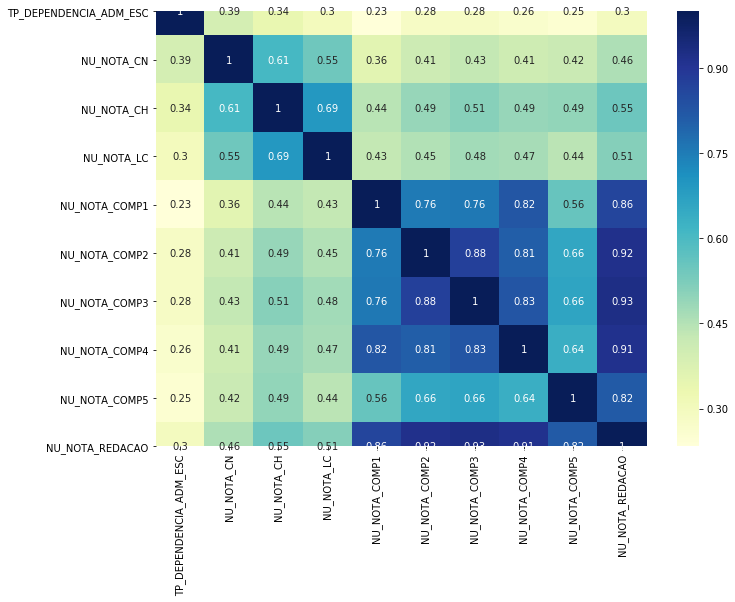

In [36]:
# Plotando as correlações em um heatmap
features_list = features.index.to_list()
corr = df[features_list].corr()
ax = plt.subplots(figsize=(11, 8))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10},cmap="YlGnBu")

In [37]:
# Verificar valores nulos
df[features_list].isnull().sum()

TP_DEPENDENCIA_ADM_ESC    9448
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
NU_NOTA_COMP1             3597
NU_NOTA_COMP2             3597
NU_NOTA_COMP3             3597
NU_NOTA_COMP4             3597
NU_NOTA_COMP5             3597
NU_NOTA_REDACAO           3597
dtype: int64

In [38]:
df['NU_NOTA_MT'].isnull().sum()

3597

In [39]:
## Para evitar treinar resposta de valores nulos, utilizar a variável alvo como index
features_list.append('NU_NOTA_MT')

In [40]:
## Substituir NAs por Zero, já que não temos amostra suficiente para excluir essas linhas
df1 = df.copy()
df1test = dftest.copy()

In [41]:
## Função para alterar todas os valores nulos por 0
def zeroFill(data):
    for item in features_list:
        data[item] = data[item].fillna(0)
    return data

In [42]:
df1 = zeroFill(df1)

In [43]:
df1test = df1test.fillna(0)

In [44]:
# Criando dataset de respostas
df_result = pd.DataFrame()

In [45]:
# Adicionando número de inscrição a ser salvo no arquivo de resposta final
df_result['NU_INSCRICAO'] = dftest['NU_INSCRICAO']

In [46]:
# Removendo a variável target
features_list.remove('NU_NOTA_MT')

In [47]:
## Definindo a função para testar os modelos
def validaPerformanceModelos(pipelines,x_train,y_train):
    results = []
    names = []
    for name, model in pipelines:
        kfold = KFold(n_splits=5, random_state=21, shuffle=True)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

In [26]:
# carregando bibliotecas para os modelos e métricas
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import sklearn.metrics as metrics

# Criando pipeline para os modelos
pipelines = []
pipelines.append(('LR', Pipeline([('Scaler', MinMaxScaler()),('LR',LinearRegression())])))
pipelines.append(('KNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('DTR', Pipeline([('Scaler', MinMaxScaler()),('DTR', DecisionTreeRegressor())])))
pipelines.append(('GBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('RFR', Pipeline([('Scaler', MinMaxScaler()),('RFR', RandomForestRegressor())])))

In [48]:
# Definindo X, y e teste
x_train = df1[features_list]
y_train = df1['NU_NOTA_MT']
x_test = df1test[features_list]

In [49]:
# Validar performance dos modelos selecionados pelo erro médio
validaPerformanceModelos(pipelines, x_train, y_train)

LR: -5101.872087 (135.658620)
KNN: -5048.319025 (40.537496)
DTR: -8376.546322 (395.538537)
GBM: -4050.778747 (56.332091)


C:\Users\dev_user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dev_user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dev_user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dev_user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

RFR: -4700.774337 (78.029563)


### Quanto menor o número, melhor, por isso, o modelo escolhido será o GBM

In [50]:
# Criar o modelo com o Gradient Boosting
pipe_GBM = Pipeline([('scaler',  StandardScaler()),
            ('GradientBoostingRegressor', GradientBoostingRegressor())])

In [51]:
CV_pipe_GBM = RandomizedSearchCV(estimator = pipe_GBM, param_distributions = {},cv = 5,return_train_score=True, verbose=0)

In [52]:
CV_pipe_GBM.fit(x_train, y_train)
ypred = CV_pipe_GBM.predict(x_test)

C:\Users\dev_user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [53]:
# Imputar previsão na saída do modelo
df_result['NU_NOTA_MT'] = np.around(ypred,2)

In [54]:
# Exportar arquivo de saída
df_result.to_csv('C:\Projetos\Python\Codenation\desafiogbm.csv', index = False, header=True)

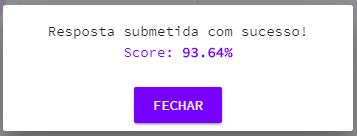

In [57]:
## Resultado
from IPython.display import Image
Image('Resultado.png')